# **Laporan Proyek Machine Learning - Syahel Rusfi Razaba**
*Prediksi Jenis Tanaman Optimal Berdasarkan Karakteristik Tanah dan Iklim Menggunakan Model Klasifikasi Machine Learning*

## **Import Library**
Mengimpor berbagai pustaka (*library*) Python yang digunakan untuk proses analisis data, visualisasi, dan pemodelan machine learning. Pustaka utama yang digunakan antara lain pandas, seaborn, matplotlib, dan pustaka dari scikit-learn.

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")

## **Load Dataset**
Membaca dataset `Crop_recommendation.csv` yang berisi data terkait karakteristik tanah dan iklim, serta label jenis tanaman yang direkomendasikan. Dataset ini memiliki 7 fitur numerik dan 1 kolom target (label) berupa jenis tanaman.

In [2]:
# Load Dataset
df = pd.read_csv("https://github.com/syahelrusfi21/Crop-Recommendation-based-on-Classification-Machine-Learning/raw/main/Crop_recommendation.csv")  # pastikan file sudah diunggah ke Colab atau Drive
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
# Informasi dataset
print("Informasi Dataset:")
df.info()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


## **Data Understanding**
Dataset yang digunakan adalah Crop Recommendation Dataset yang diperoleh dari [Kaggle](https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset).
### Informasi Dataset:
- Jumlah sampel: 2200 baris
- Jumlah fitur: 7 fitur input + 1 target output
- Target: Nama tanaman (*multi-class*)

### Fitur:
| Fitur | Deskripsi |
| ------ | ------ |
| N | Kandungan Nitrogen dalam tanah |
| P | Kandungan Fosfor dalam tanah |
| K | Kandungan Kalium dalam tanah |
| temperature | Rata-rata suhu udara (°C) |
| humidity | Rata-rata kelembapan relatif (%) |
| ph | Tingkat keasaman tanah (ph tanah) |
| rainfall | Curah hujan dalam mm |
| label | Tanaman (kelas target/output) |

## **Data Pre-Processing**


### Data Cleaning
Pemeriksaan kualitas data dilakukan pada tahap ini, yang meliputi deteksi dan penanganan:
- Data duplikat
- Nilai kosong (missing values)
- Outlier

In [4]:
# Cek data duplikat
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 0


In [5]:
# Cek missing value
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

Jumlah missing value per kolom:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


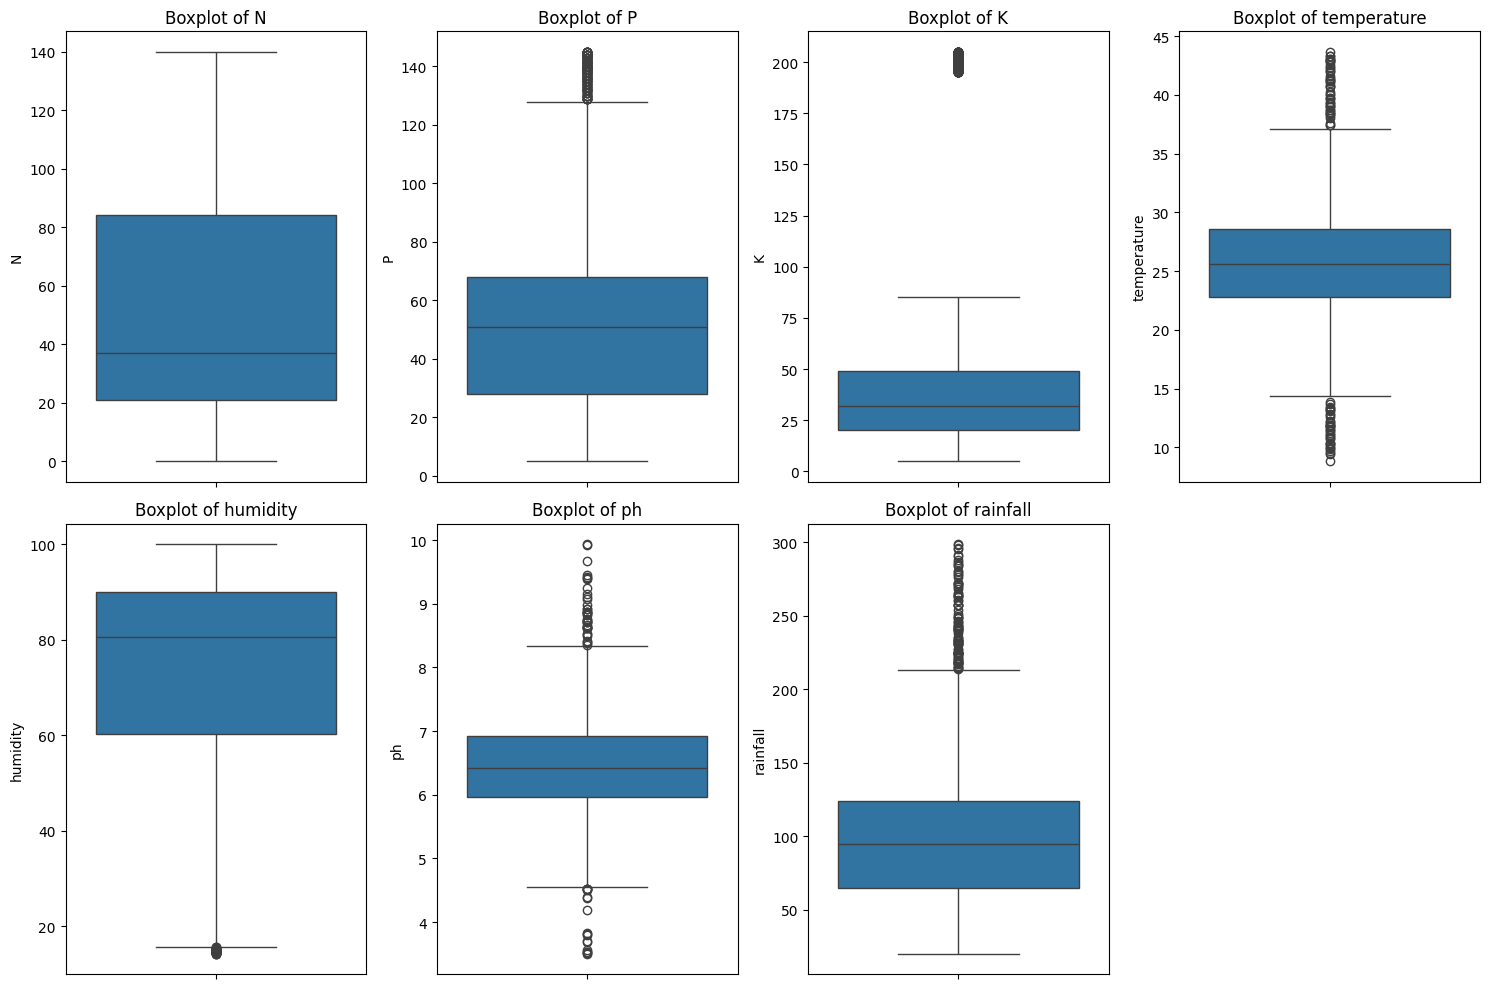

In [6]:
# Visualisasi Outlier dengan Boxplot
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1) # Sesuaikan grid berdasarkan jumlah kolom numerik
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Terlihat terdapat outlier pada beberapa variabel. Untuk menangani outlier ini, kita akan menggunakan metode transformasi yang disebut Winsorization (Capping).

Pada metode ini, nilai outlier tidak dihapus, melainkan diganti dengan nilai batas atas atau batas bawah yang dihitung berdasarkan Interquartile Range (IQR). Nilai yang melebihi Q3 + 1.5×IQR akan diganti dengan batas atas, dan nilai yang kurang dari Q1 - 1.5×IQR akan diganti dengan batas bawah.

Pendekatan ini dipilih untuk menjaga ukuran dataset tetap utuh sekaligus mengurangi dampak nilai ekstrem pada analisis.

In [7]:
# Salin data asli
df_transformed = df.copy()

# Daftar fitur numerik
numerical_features = df_transformed.drop(columns='label').columns

# Winsorization: Batasi nilai outlier ke batas IQR
for col in numerical_features:
    Q1 = df_transformed[col].quantile(0.25)
    Q3 = df_transformed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_transformed[col] = np.where(df_transformed[col] < lower_bound, lower_bound,
                            np.where(df_transformed[col] > upper_bound, upper_bound, df_transformed[col]))

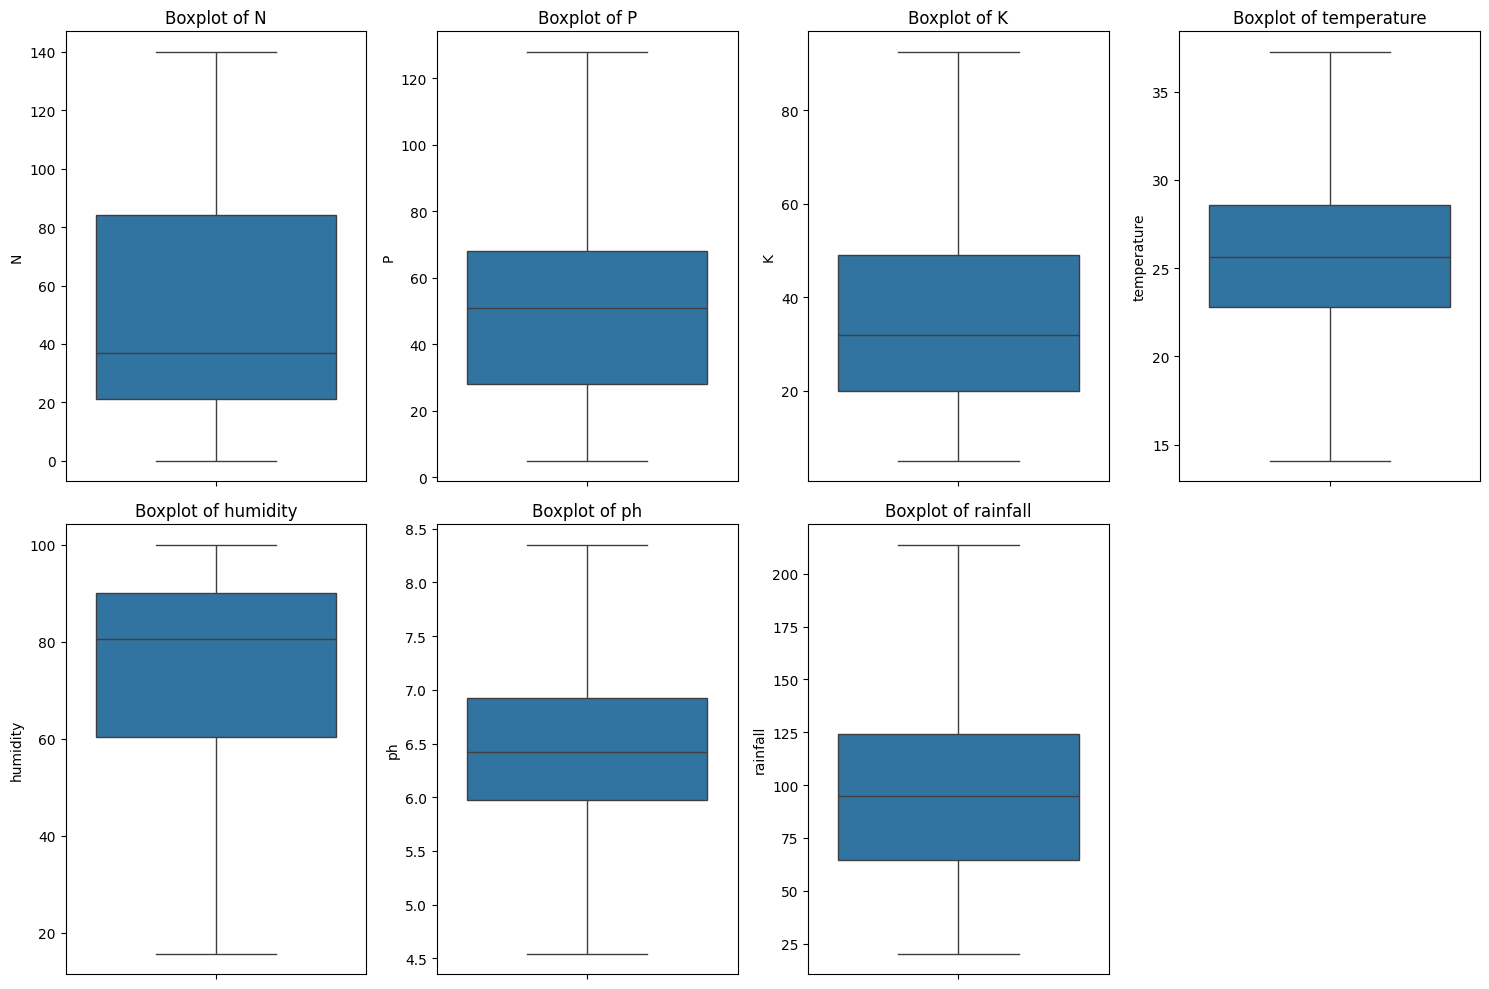

In [8]:
# Visualisasi Outlier dengan Boxplot setelah Transformasi
numerical_cols_transformed = df_transformed.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_transformed):
    plt.subplot(2, 4, i + 1) # Sesuaikan grid berdasarkan jumlah kolom numerik
    sns.boxplot(y=df_transformed[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Setelah melakukan transformasi, terlihat pada visualisasi boxplot di atas bahwa outlier sudah ditangani.

### Exploratory Data Analysis (EDA)
EDA bertujuan memahami pola dan distribusi dalam data, serta membantu mengenali hubungan antar fitur. Analisis dilakukan melalui:
- Statistik deskriptif
- Korelasi antar fitur
- Visualisasi distribusi kelas target

In [9]:
# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df_transformed.describe())


Statistik Deskriptif:
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    52.743182    38.376364    25.588740    71.493347   
std      36.917334    31.427156    23.460322     4.738804    22.234536   
min       0.000000     5.000000     5.000000    14.080956    15.731726   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   128.000000    92.500000    37.250073    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.464205   101.986465  
std       0.730288    51.165743  
min       4.543768    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       8.351567   213.841241  


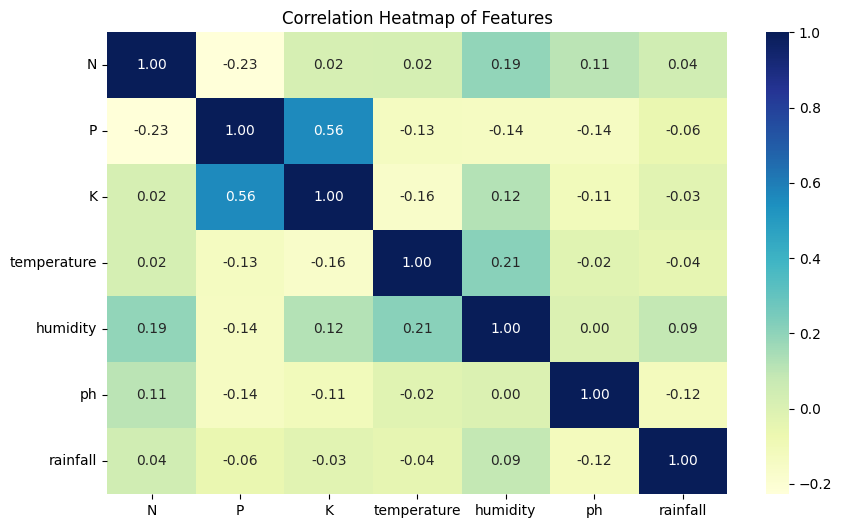

In [10]:
# Korelasi antar fitur
plt.figure(figsize=(10, 6))
sns.heatmap(df_transformed.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

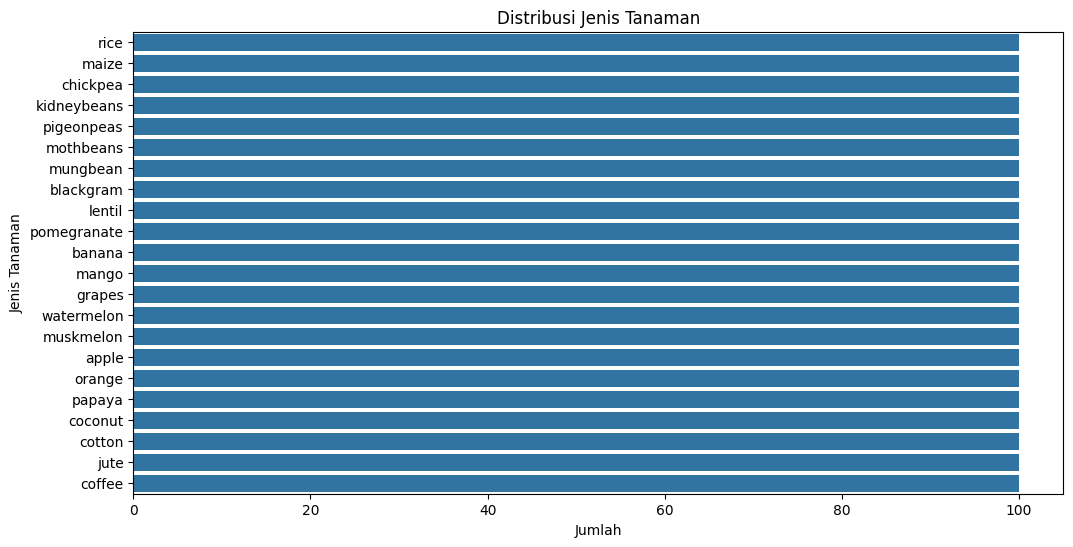

In [11]:
# Distribusi kelas target
plt.figure(figsize=(12, 6))
sns.countplot(y='label', data=df_transformed, order=df_transformed['label'].value_counts().index)
plt.title("Distribusi Jenis Tanaman")
plt.xlabel("Jumlah")
plt.ylabel("Jenis Tanaman")
plt.show()

### Data Transformation and Splitting
Transformasi dilakukan agar data dalam bentuk numerik dan memiliki skala yang seragam:

- **Label Encoding**: Mengubah label tanaman dari bentuk teks menjadi nilai numerik menggunakan LabelEncoder.
- **Normalisasi**: Menggunakan MinMaxScaler untuk mengubah skala semua fitur numerik ke rentang 0–1 agar seimbang dalam perhitungan algoritma.

Dataset dibagi menjadi dua bagian:
- Data Latih (*Training Set*): Digunakan untuk melatih model
- Data Uji (*Test Set*): Digunakan untuk mengevaluasi performa model

In [12]:
# Pisahkan fitur dan label
X = df_transformed.drop("label", axis=1)
y = df_transformed["label"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalisasi fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")

Jumlah data latih: 1760
Jumlah data uji: 440


## **Modeling**
Melatih tiga algoritma klasifikasi yang umum digunakan dalam *supervised learning*:
- K-Nearest Neighbors (KNN)
- Decision Tree
- Random Forest

In [13]:
# Inisialisasi model
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Melatih & evaluasi model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    results[name] = {
        "accuracy": acc,
        "f1_score": report["weighted avg"]["f1-score"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"]
    }

# Tampilkan hasil
pd.DataFrame(results).T.sort_values(by="accuracy", ascending=False)

,accuracy,f1_score,precision,recall
Random Forest,0.993182,0.993175,0.993735,0.993182
Decision Tree,0.986364,0.986315,0.986806,0.986364
KNN,0.970455,0.970638,0.975117,0.970455


## **Evaluation**
Menampilkan confusion matrix dari model terbaik (Random Forest) untuk memperlihatkan detail klasifikasi per kelas. Matriks ini berguna untuk mengidentifikasi jumlah prediksi benar dan salah, serta menilai distribusi kesalahan model terhadap tiap kelas tanaman.

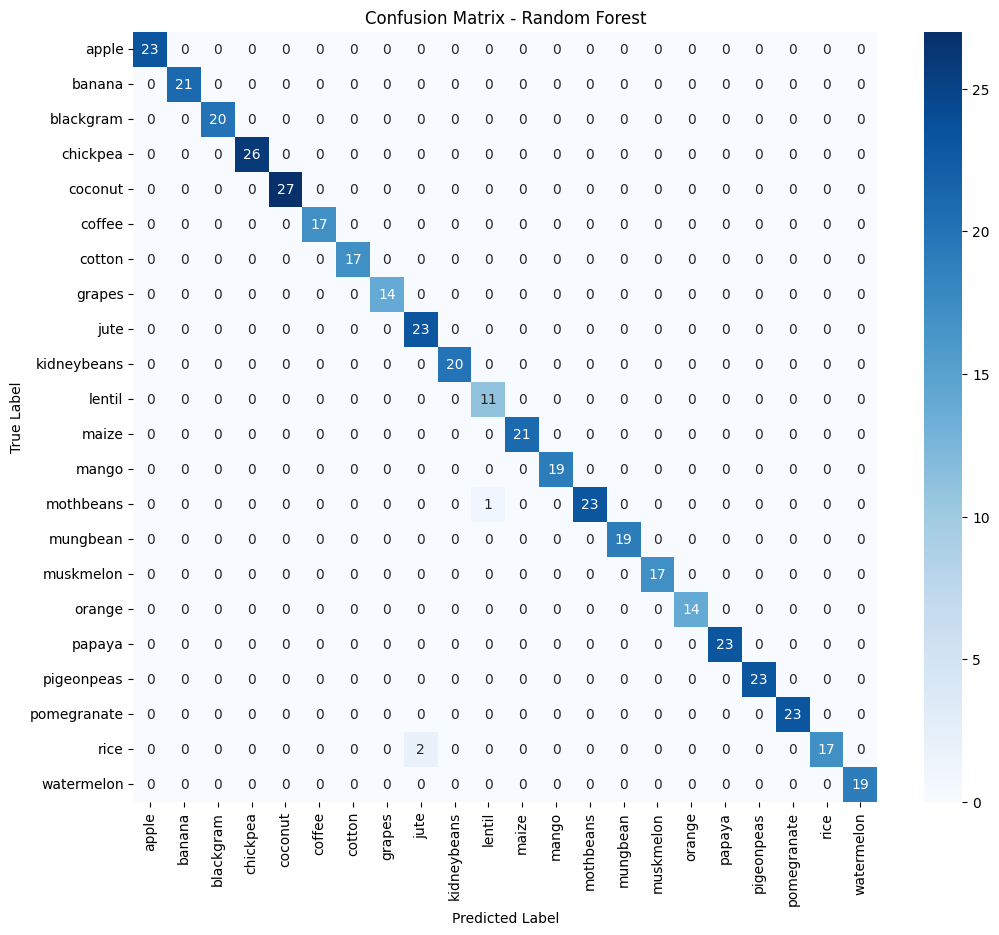

In [14]:
# 📏 6. Confusion Matrix untuk Model Terbaik (Random Forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **Save Best Model**
Menyimpan model Random Forest yang telah dilatih menggunakan library joblib. Model yang disimpan dapat digunakan kembali tanpa perlu melatih ulang.

In [15]:
# Simpan model Random Forest terbaik
joblib.dump(rf, 'random_forest_model.pkl')

print("Model Random Forest terbaik telah disimpan sebagai 'random_forest_model.pkl'")

Model Random Forest terbaik telah disimpan sebagai 'random_forest_model.pkl'
